In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
# checkpoint -> result 불러오기
import argparse
import torch
import torch.nn as nn
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
from exp.exp_imputation import Exp_Imputation
from exp.exp_short_term_forecasting import Exp_Short_Term_Forecast
from exp.exp_long_term_forecasting_partial import Exp_Long_Term_Forecast_Partial
from exp.exp_anomaly_detection import Exp_Anomaly_Detection
from exp.exp_classification import Exp_Classification
from utils.print_args import print_args
import random
import time

In [3]:
# fix random seed
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
parser = argparse.ArgumentParser(description='TimesNet')

In [4]:
# config 지정 -> 오류 방지를 위해 

# basic config
parser.add_argument('--task_name', type=str, default='long_term_forecast',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser.add_argument('--is_training', type=int, default=1, help='status')
parser.add_argument('--model_id', type=str, default='test', help='model id')
parser.add_argument('--model', type=str, default='Autoformer',
                    help='model name, options: [Autoformer, Transformer, TimesNet]')

# data loader
parser.add_argument('--data', type=str, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# added option 
parser.add_argument('--train_ratio', type=float, default=0.7, help='train data ratio')
parser.add_argument('--test_ratio', type=float, default=0.2, help='test data ratio')
parser.add_argument('--train_step', type=float, default=1.0, help='train data with certain stes. for example train_step=2 means only train even number of data')

# SparseTSF
parser.add_argument('--period_len', type=int, default=24, help='period length')

# PITS
parser.add_argument('--fc_dropout', type=float, default=0.05, help='fully connected dropout')
parser.add_argument('--head_dropout', type=float, default=0.0, help='head dropout')
parser.add_argument('--patch_len', type=int, default=16, help='patch length')
parser.add_argument('--stride', type=int, default=8, help='stride')
parser.add_argument('--shared_embedding', type=int, default=1, help='stride')
parser.add_argument('--padding_patch', default='end', help='None: None; end: padding on the end')
parser.add_argument('--revin', type=int, default=1, help='RevIN; True 1 False 0')
parser.add_argument('--affine', type=int, default=0, help='RevIN-affine; True 1 False 0')
parser.add_argument('--subtract_last', type=int, default=0, help='0: subtract mean; 1: subtract last')
parser.add_argument('--decomposition', type=int, default=0, help='decomposition; True 1 False 0')
parser.add_argument('--kernel_size', type=int, default=25, help='decomposition-kernel')
parser.add_argument('--individual', type=int, default=0, help='individual head; True 1 False 0')

# Piformer
parser.add_argument('--joint_var', type=int, default=0, help='use attention for each patching; True 1 False 0')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')
parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)

# inputation task
parser.add_argument('--mask_rate', type=float, default=0.25, help='mask ratio')

# anomaly detection task
parser.add_argument('--anomaly_ratio', type=float, default=0.25, help='prior anomaly ratio (%)')

# model define
parser.add_argument('--expand', type=int, default=2, help='expansion factor for Mamba')
parser.add_argument('--d_conv', type=int, default=4, help='conv kernel size for Mamba')
parser.add_argument('--top_k', type=int, default=5, help='for TimesBlock')
parser.add_argument('--num_kernels', type=int, default=6, help='for Inception')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--channel_independence', type=int, default=1,
                    help='0: channel dependence 1: channel independence for FreTS model')
parser.add_argument('--decomp_method', type=str, default='moving_avg',
                    help='method of series decompsition, only support moving_avg or dft_decomp')
parser.add_argument('--use_norm', type=int, default=1, help='whether to use normalize; True 1 False 0')
parser.add_argument('--down_sampling_layers', type=int, default=0, help='num of down sampling layers')
parser.add_argument('--down_sampling_window', type=int, default=1, help='down sampling window size')
parser.add_argument('--down_sampling_method', type=str, default=None,
                    help='down sampling method, only support avg, max, conv')
parser.add_argument('--seg_len', type=int, default=48,
                    help='the length of segmen-wise iteration of SegRNN')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='MSE', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# de-stationary projector params
parser.add_argument('--p_hidden_dims', type=int, nargs='+', default=[128, 128],
                    help='hidden layer dimensions of projector (List)')
parser.add_argument('--p_hidden_layers', type=int, default=2, help='number of hidden layers in projector')

# metrics (dtw)
parser.add_argument('--use_dtw', type=bool, default=False, 
                    help='the controller of using dtw metric (dtw is time consuming, not suggested unless necessary)')

# Augmentation
parser.add_argument('--augmentation_ratio', type=int, default=0, help="How many times to augment")
parser.add_argument('--seed', type=int, default=2, help="Randomization seed")
parser.add_argument('--jitter', default=False, action="store_true", help="Jitter preset augmentation")
parser.add_argument('--scaling', default=False, action="store_true", help="Scaling preset augmentation")
parser.add_argument('--permutation', default=False, action="store_true", help="Equal Length Permutation preset augmentation")
parser.add_argument('--randompermutation', default=False, action="store_true", help="Random Length Permutation preset augmentation")
parser.add_argument('--magwarp', default=False, action="store_true", help="Magnitude warp preset augmentation")
parser.add_argument('--timewarp', default=False, action="store_true", help="Time warp preset augmentation")
parser.add_argument('--windowslice', default=False, action="store_true", help="Window slice preset augmentation")
parser.add_argument('--windowwarp', default=False, action="store_true", help="Window warp preset augmentation")
parser.add_argument('--rotation', default=False, action="store_true", help="Rotation preset augmentation")
parser.add_argument('--spawner', default=False, action="store_true", help="SPAWNER preset augmentation")
parser.add_argument('--dtwwarp', default=False, action="store_true", help="DTW warp preset augmentation")
parser.add_argument('--shapedtwwarp', default=False, action="store_true", help="Shape DTW warp preset augmentation")
parser.add_argument('--wdba', default=False, action="store_true", help="Weighted DBA preset augmentation")
parser.add_argument('--discdtw', default=False, action="store_true", help="Discrimitive DTW warp preset augmentation")
parser.add_argument('--discsdtw', default=False, action="store_true", help="Discrimitive shapeDTW warp preset augmentation")
parser.add_argument('--extra_tag', type=str, default="", help="Anything extra")

#piformer
parser.add_argument('--shuffle', type=int, default=1, help="Shuffle data when training")
parser.add_argument('--base_model', type=str, default="iTransformer", help="Base Model Type")

_StoreAction(option_strings=['--base_model'], dest='base_model', nargs=None, const=None, default='iTransformer', type=<class 'str'>, choices=None, help='Base Model Type', metavar=None)

In [5]:
# argument_text로 parser의 argument 지정 - 반드시 불러오는 모델과 동일하게 지정해야 함.

parse_seq = """  --task_name long_term_forecast \
  --is_training 1 \
  --root_path ./dataset/exchange_rate/ \
  --data_path exchange_rate.csv \
  --model_id DiTransformer_Exchange_96_96\
  --model DiTransformer_decomp \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 8 \
  --dec_in 8 \
  --c_out 8 \
  --batch_size 4 \
  --train_ratio 0.6 \
  --d_model 64 \
  --d_ff 128 \
  --des 'Exp' \
  --shuffle 0\
  --itr 1
"""
args = parser.parse_args(parse_seq.split())
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

print('Args in experiment:')
print(args)

Args in experiment:
Namespace(activation='gelu', affine=0, anomaly_ratio=0.25, augmentation_ratio=0, base_model='iTransformer', batch_size=4, c_out=8, channel_independence=1, checkpoints='./checkpoints/', d_conv=4, d_ff=128, d_layers=1, d_model=64, data='custom', data_path='exchange_rate.csv', dec_in=8, decomp_method='moving_avg', decomposition=0, des="'Exp'", devices='0,1,2,3', discdtw=False, discsdtw=False, distil=True, down_sampling_layers=0, down_sampling_method=None, down_sampling_window=1, dropout=0.1, dtwwarp=False, e_layers=2, embed='timeF', enc_in=8, expand=2, extra_tag='', factor=3, fc_dropout=0.05, features='M', freq='h', gpu=0, head_dropout=0.0, individual=0, inverse=False, is_training=1, itr=1, jitter=False, joint_var=0, kernel_size=25, label_len=48, learning_rate=0.0001, loss='MSE', lradj='type1', magwarp=False, mask_rate=0.25, model='DiTransformer_decomp', model_id='DiTransformer_Exchange_96_96', moving_avg=25, n_heads=8, num_kernels=6, num_workers=10, output_attention=F

In [6]:
# 모델 호출 - Exp_Long_Term_Forecast
exp_model = Exp_Long_Term_Forecast(args)
exp_model._build_model()

Use GPU: cuda:0


Model(
  (decomposition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (enc_embedding_s): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (linear_adjustment): LinearApproximation(
    (linear): Linear(in_features=1, out_features=8, bias=True)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=64, out_features=64, bias=True)
          (key_projection): Linear(in_features=64, out_features=64, bias=True)
          (valu

In [8]:
iTransformer_result = 'long_term_forecast_DiTransformer_Exchange_96_96_lin2_origin8_Mod-DiTransformer_decomp_data-exchange_rate.csv_(96to96)_0(1727108875)'

In [9]:
# 위의 argument와 맞는 모델 호출
checkpoint_path = './checkpoints/'
setting_path = iTransformer_result
model_path = f"{checkpoint_path}{setting_path}/checkpoint.pth"
exp_model.model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [10]:
%matplotlib inline

In [11]:
from utils.metrics import *
from utils.tools import linear_regression_direct, linear_predict
from data_provider.data_factory import data_provider
from data_provider.data_loader import Dataset_Custom

In [12]:
# data_provider -> Exchange_rate
dataset_exchange_96 = Dataset_Custom(args, './dataset/exchange_rate/',
                                    flag='train', size=(96, 48, 96),
                                    features='M', data_path = 'exchange_rate.csv',
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=0.6, test_ratio=0.2)
dataset_exchange_96_test = Dataset_Custom(args, './dataset/exchange_rate/',
                                    flag='test', size=(96, 48, 96),
                                    features='M', data_path = 'exchange_rate.csv',
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=0.6, test_ratio=0.2)

In [13]:
exp_model.model.eval()

Model(
  (decomposition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (enc_embedding_s): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (linear_adjustment): LinearApproximation(
    (linear): Linear(in_features=1, out_features=8, bias=True)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=64, out_features=64, bias=True)
          (key_projection): Linear(in_features=64, out_features=64, bias=True)
          (valu

In [14]:
# 모델 훈련셋 결과 확인하기
from data_provider.data_factory import data_provider
from torch.utils.data import DataLoader

dataset_exchange_96_loader = DataLoader(
            dataset_exchange_96,
            batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=False)

In [15]:
dataset_exchange_96_loader = DataLoader(
            dataset_exchange_96,
            batch_size=8, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=False)

In [16]:
dataset_exchange_96[0][0].shape, dataset_exchange_96[0][1].shape

((96, 8), (144, 8))

In [17]:
X = np.array([[t] for t in range(-args.seq_len, 0)])  # X는 입력 feature, shape: [seq_len, 1]
X_new = np.array([[t] for t in range(args.seq_len)])  # 예측을 위한 새로운 시간 변수

In [18]:
X.shape

(96, 1)

In [19]:
theta_best = linear_regression_direct(torch.Tensor(X), dataset_exchange_96[0][0][:,0], exp_model.device)

In [20]:
linear_predict(X_new, theta_best, exp_model.device)

tensor([0.5581, 0.5555, 0.5528, 0.5502, 0.5475, 0.5448, 0.5422, 0.5395, 0.5369,
        0.5342, 0.5315, 0.5289, 0.5262, 0.5236, 0.5209, 0.5183, 0.5156, 0.5129,
        0.5103, 0.5076, 0.5050, 0.5023, 0.4996, 0.4970, 0.4943, 0.4917, 0.4890,
        0.4863, 0.4837, 0.4810, 0.4784, 0.4757, 0.4730, 0.4704, 0.4677, 0.4651,
        0.4624, 0.4598, 0.4571, 0.4544, 0.4518, 0.4491, 0.4465, 0.4438, 0.4411,
        0.4385, 0.4358, 0.4332, 0.4305, 0.4278, 0.4252, 0.4225, 0.4199, 0.4172,
        0.4145, 0.4119, 0.4092, 0.4066, 0.4039, 0.4013, 0.3986, 0.3959, 0.3933,
        0.3906, 0.3880, 0.3853, 0.3826, 0.3800, 0.3773, 0.3747, 0.3720, 0.3693,
        0.3667, 0.3640, 0.3614, 0.3587, 0.3560, 0.3534, 0.3507, 0.3481, 0.3454,
        0.3427, 0.3401, 0.3374, 0.3348, 0.3321, 0.3295, 0.3268, 0.3241, 0.3215,
        0.3188, 0.3162, 0.3135, 0.3108, 0.3082, 0.3055], device='cuda:0',
       grad_fn=<SqueezeBackward1>)

In [21]:
linear_predict(X_new, theta_best, exp_model.device).shape

torch.Size([96])

In [22]:
resx = np.concatenate([X, X_new], axis=0).reshape(-1)

batch_x_torch = torch.Tensor(dataset_exchange_96[0][0]).unsqueeze(0).to(exp_model.device)

In [23]:
res1 = exp_model.model(batch_x_torch, None, batch_x_torch, None)[0].detach().cpu().numpy()
res1.squeeze()

array([[ 0.6551344 ,  0.13205807,  0.9933246 , -0.18903664,  2.716595  ,
        -2.2586594 , -1.5488439 , -0.19452885],
       [ 0.65242994,  0.12832807,  0.96360654, -0.17644309,  2.7118914 ,
        -2.2838056 , -1.535149  , -0.20279126],
       [ 0.6571083 ,  0.1598894 ,  0.99675035, -0.18681456,  2.7147763 ,
        -2.2395089 , -1.5567951 , -0.18590643],
       [ 0.6627549 ,  0.12443849,  0.97682315, -0.216352  ,  2.715311  ,
        -2.2696004 , -1.5535208 , -0.18560827],
       [ 0.65445024,  0.11850718,  0.99503267, -0.18540905,  2.7162964 ,
        -2.2675693 , -1.5477548 , -0.18949127],
       [ 0.66473854,  0.10075434,  0.98826915, -0.19152302,  2.7138717 ,
        -2.22321   , -1.550703  , -0.18605734],
       [ 0.68142676,  0.15897112,  1.0127926 , -0.1426265 ,  2.7163014 ,
        -2.2198489 , -1.5330589 , -0.17189962],
       [ 0.6474913 ,  0.14685428,  0.98374796, -0.14428017,  2.7175946 ,
        -2.2153645 , -1.5451422 , -0.18048647],
       [ 0.69025457,  0.12505616

In [24]:
rt = res1.squeeze()
lix_lin_before = [linear_predict(X, linear_regression_direct(torch.Tensor(X), dataset_exchange_96[0][0][:,v], exp_model.device), exp_model.device) for v in range(8)]
lix_linear = [linear_predict(X_new, linear_regression_direct(torch.Tensor(X), dataset_exchange_96[0][0][:,v], exp_model.device), exp_model.device) for v in range(8)]

In [25]:
lix_lin_before_24 = [linear_predict(X, linear_regression_direct(torch.Tensor(X[-24:]), dataset_exchange_96[0][0][-24:,v], exp_model.device), exp_model.device) for v in range(8)]
lix_linear_24 = [linear_predict(X_new, linear_regression_direct(torch.Tensor(X[-24:]), dataset_exchange_96[0][0][-24:,v], exp_model.device), exp_model.device) for v in range(8)]

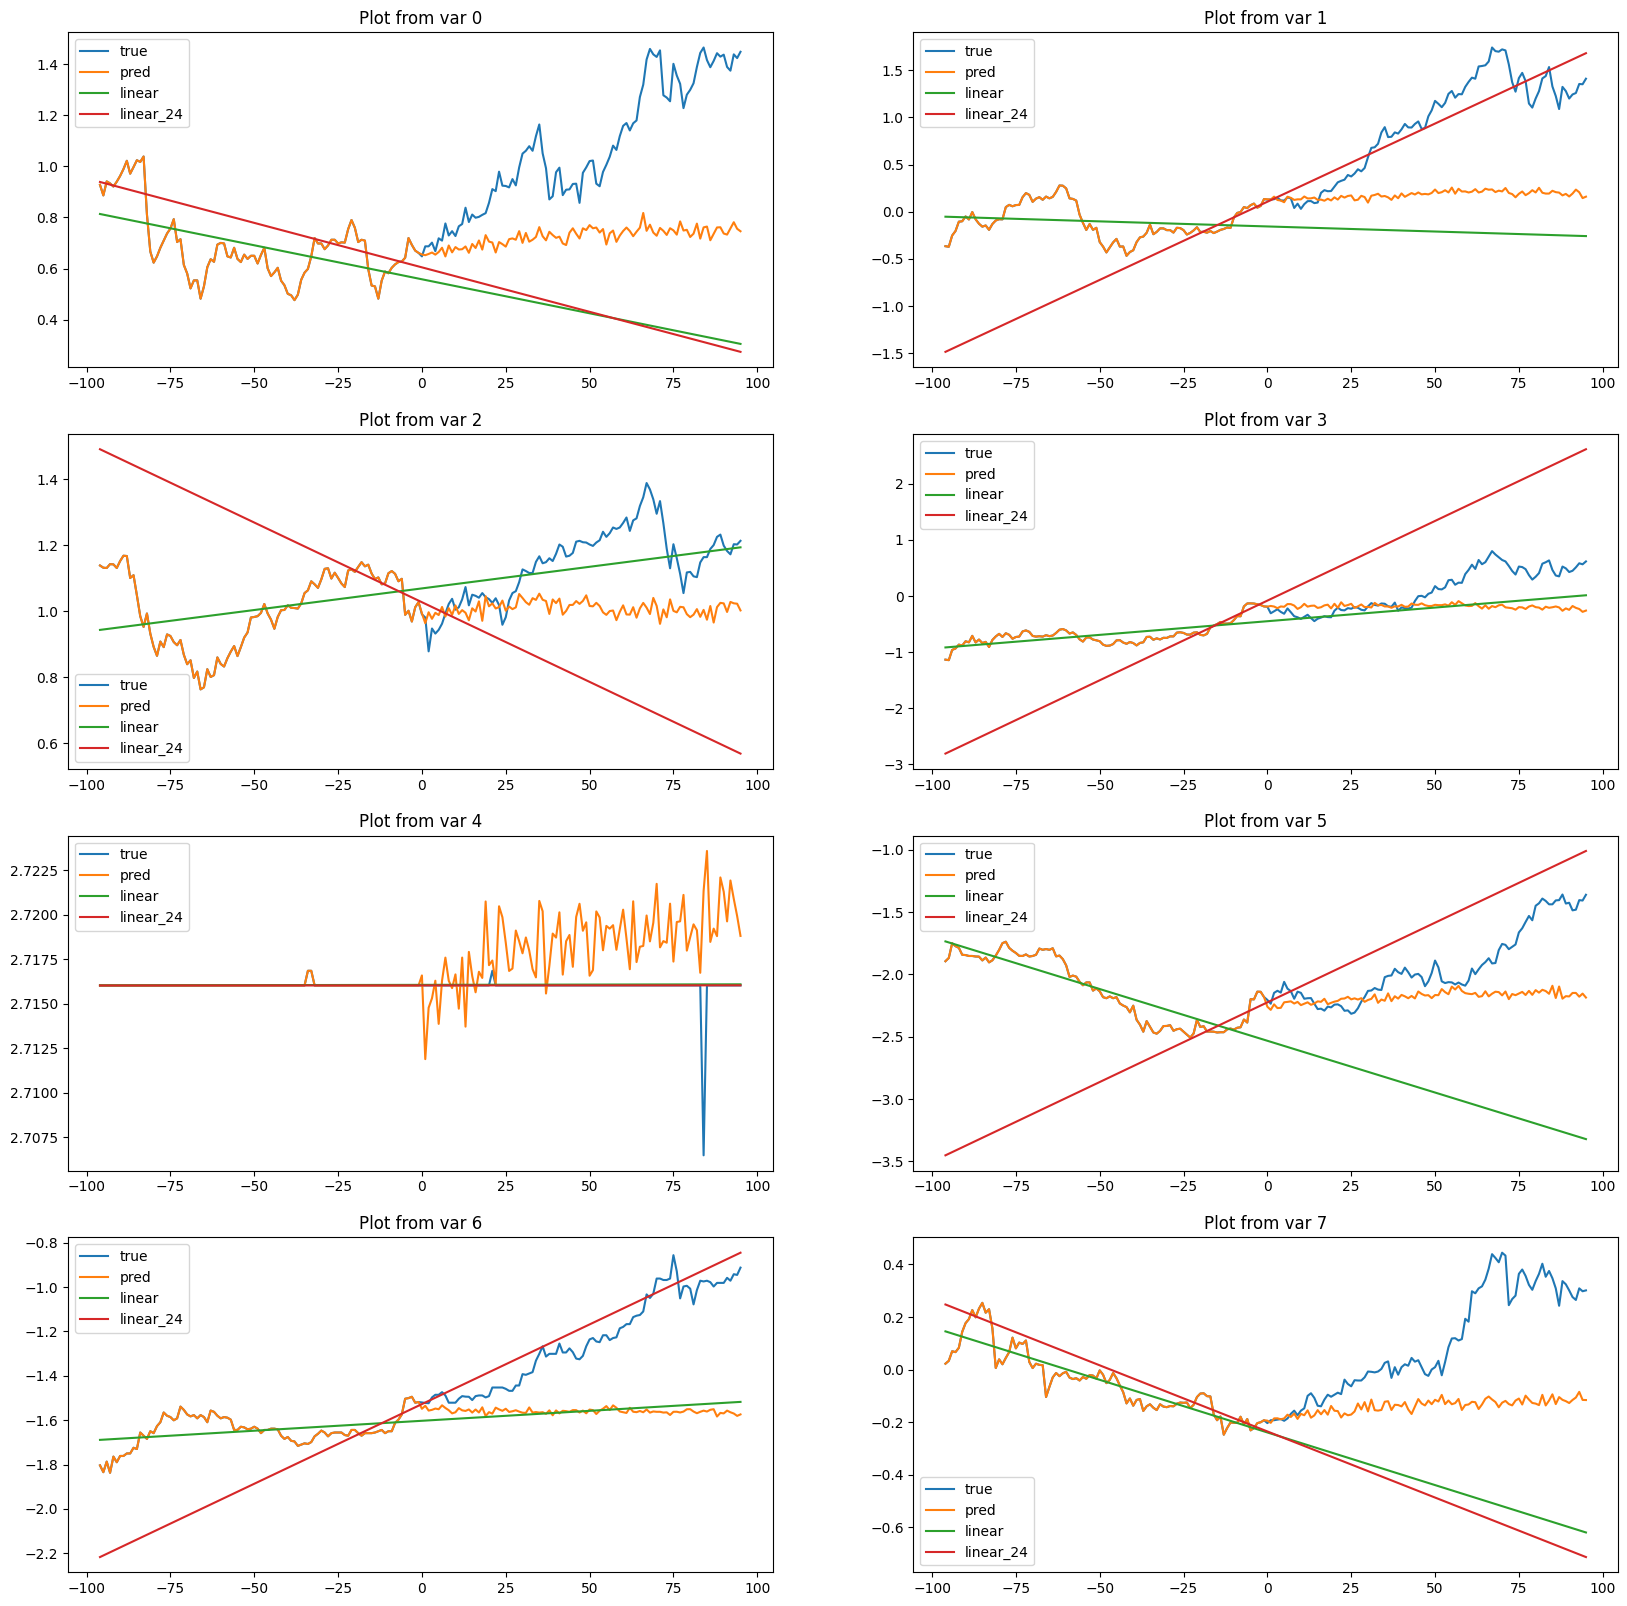

In [26]:
# 4*2 그래프 그리기
# iTransformer 예측, linear예측, 실제값 
idx = 0
fig, axs = plt.subplots(4, 2, figsize=(20, 20))  # 5행 10열 서브플롯, figure 크기 조정

for i in range(4):
    for j in range(2):
        val = i*2 + j
        y0 = dataset_exchange_96[idx][0][:, val] # 시작값
        y_true = dataset_exchange_96[idx][1][-96:, val] # 참값
        y_pred = rt[:, val]
        y_lin_before = lix_lin_before[val].detach().cpu().numpy()
        y_lin = lix_linear[val].detach().cpu().numpy()
        y_lin_before_24 = lix_lin_before_24[val].detach().cpu().numpy()
        y_lin_24 = lix_linear_24[val].detach().cpu().numpy()
        ax = axs[i, j]
        ax.plot(resx, np.concatenate([y0, y_true]), label='true')  # 예제: 서로 다른 사인 곡선 플롯
        ax.plot(resx, np.concatenate([y0, y_pred]), label='pred')
        ax.plot(resx, np.concatenate([y_lin_before, y_lin]), label='linear')
        ax.plot(resx, np.concatenate([y_lin_before_24, y_lin_24]), label='linear_24')
        ax.set_title(f'Plot from var {(i*2 + j)}')
        ax.legend()
        # ax.axis('off')  # 축을 끄고 싶다면 사용

plt.show()

In [27]:
# 우선 train_set의 data_exchange를 바탕으로 측정값 참값 가져기
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr = [] # 예측값
trues_te_tr = [] # 참값
preds_te_lin = [] # 96_lin
preds_te_lin_24 = [] # 24_lin

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    batch_x = batch_x.float().to(exp_model.device)
    batch_y = batch_y.float().to(exp_model.device)

    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)

    batch_x_mark = batch_x_mark.float().to(exp_model.device)
    batch_y_mark = batch_y_mark.float().to(exp_model.device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp_model.device)
    # encoder - decoder

    # use_amp도 사용하지 않음, 
    outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
    
    # 각 배치와 변수에 대해 선형 회귀 해를 계산
    vals = [[linear_regression_direct(X, batch_x.permute(0,2,1)[idx, var , :], exp_model.device) for var in range(N)] for idx in range(B)]
    lin_result = [[linear_predict(X_new, vals[idx][var], exp_model.device) for var in range(N)] for idx in range(B)]
    # 결과를 3D 텐서로 변환
    lin_result = torch.stack([torch.stack(lin_result[idx], dim=0) for idx in range(B)], dim=0).to(exp_model.device)

    # 24 조각에 대해서도 계산
    vals_24 = [[linear_regression_direct(X[-24:], batch_x.permute(0,2,1)[idx, var , -24:], exp_model.device) for var in range(N)] for idx in range(B)]
    lin_result_24 = [[linear_predict(X_new, vals_24[idx][var], exp_model.device) for var in range(N)] for idx in range(B)]
    # 결과를 3D 텐서로 변환
    lin_result_24 = torch.stack([torch.stack(lin_result_24[idx], dim=0) for idx in range(B)], dim=0).to(exp_model.device)
    
    outputs = outputs[:, -args.pred_len:, :]
    batch_y = batch_y[:, -args.pred_len:, :].to(exp_model.device)
    outputs = outputs.detach().cpu().numpy()
    batch_y = batch_y.detach().cpu().numpy()

    pred = outputs
    true = batch_y

    preds_te_tr.append(pred)
    trues_te_tr.append(true)
    preds_te_lin.append(lin_result)
    preds_te_lin_24.append(lin_result_24)

    if (i+1)%100==0:
        print(f"step {i+1} completed")
    
preds_te_tr = np.concatenate(preds_te_tr, axis=0)
trues_te_tr = np.concatenate(trues_te_tr, axis=0)


step 100 completed
step 200 completed
step 300 completed
step 400 completed
step 500 completed


In [28]:
preds_te_lin = torch.concat(preds_te_lin, axis=0).detach().cpu().numpy()
preds_te_lin_24 = torch.concat(preds_te_lin_24, axis=0).detach().cpu().numpy()

In [29]:
preds_te_lin = np.transpose(preds_te_lin, (0,2,1))
preds_te_lin_24 = np.transpose(preds_te_lin_24, (0,2,1))

In [30]:
# 마지막으로 torch 모델을 제작 > 훈련
class CombinedModel(nn.Module):
    def __init__(self, res_A, res_B, res_C):
        super(CombinedModel, self).__init__()
        self.res_A = res_A  # iTransformer train_result
        self.res_B = res_B  # lin_reg_96 train_result
        self.res_C = res_C
        self.a = nn.Parameter(torch.ones(1, device=exp_model.device)*0.2, requires_grad=True)
        self.b = nn.Parameter(torch.zeros(1, device=exp_model.device), requires_grad=True)
        self.c = nn.Parameter(torch.zeros(1, device=exp_model.device), requires_grad=True)
        # self.d = nn.Parameter(torch.zeros(1, device=exp_model.device), requires_grad=True)
    
    def forward(self, x):
        output_A = self.res_A(x)
        output_B = self.res_B(x)
        output_C = self.res_C(x)
        combined_output = self.a * output_A + self.b * output_B + output_C * self.c # + self.d
        return combined_output

In [31]:
# model_output_function

def res_iTransformer(batch_x):
    
    return exp_model.model(batch_x, None, torch.zeros_like(batch_x), None)[0]

def res_lin_reg(batch_x):
    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)
    # 각 배치와 변수에 대해 선형 회귀 해를 계산
    vals = [[linear_regression_direct(X, batch_x.permute(0,2,1)[idx, var , :], exp_model.device) for var in range(N)] for idx in range(B)]
    lin_result = [[linear_predict(X_new, vals[idx][var], exp_model.device) for var in range(N)] for idx in range(B)]
    # 결과를 3D 텐서로 변환
    lin_result = torch.stack([torch.stack(lin_result[idx], dim=0) for idx in range(B)], dim=0).to(exp_model.device).permute(0,2,1)
    return lin_result

def res_lin_reg_24(batch_x):
    B, L, N = batch_x.shape  # L은 시퀀스 길이(seq_len)
    # 24 조각에 대해서도 계산
    vals_24 = [[linear_regression_direct(X[-24:], batch_x.permute(0,2,1)[idx, var , -24:], exp_model.device) for var in range(N)] for idx in range(B)]
    lin_result_24 = [[linear_predict(X_new, vals_24[idx][var], exp_model.device) for var in range(N)] for idx in range(B)]
    # 결과를 3D 텐서로 변환
    lin_result_24 = torch.stack([torch.stack(lin_result_24[idx], dim=0) for idx in range(B)], dim=0).to(exp_model.device).permute(0,2,1)
    return lin_result_24

In [32]:
combine_model_test = CombinedModel(res_iTransformer, res_lin_reg, res_lin_reg_24)

In [33]:
combined_outputs = []
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    batch_x = batch_x.float().to(exp_model.device)
    batch_y = batch_y.float().to(exp_model.device)
    combined_output = combine_model_test(batch_x)
    combined_outputs.append(combined_output)
    if (i+1)%100==0:
        print(f"step {i+1} completed")

step 100 completed
step 200 completed
step 300 completed
step 400 completed
step 500 completed


In [34]:
combined_outputs[0].shape

torch.Size([8, 96, 8])

In [35]:
combine_model_test.a, combine_model_test.b, combine_model_test.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.2000], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.], device='cuda:0', requires_grad=True))

In [36]:
num_epochs = 1
combine_model_test = CombinedModel(res_iTransformer, res_lin_reg, res_lin_reg_24)
# combine_model_test training
combine_model_test.train()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam([combine_model_test.a, combine_model_test.b, combine_model_test.c], lr=0.0005)


In [37]:
# 일부만 테스트
random_val = 0.5
train_len = len(dataset_exchange_96)
selected_indices = [int(i/random_val) for i in range(int(train_len*random_val)+1) ]

In [38]:
cnt = 0
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    # if i in selected_indices:
        cnt += 1
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
        targets = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        optimizer.zero_grad()
        outputs = combine_model_test(batch_x)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (cnt+1) % 100 == 0:
            print(f"epoch {cnt+1} done, loss {loss}") 

epoch 100 done, loss 0.28377294540405273
epoch 200 done, loss 0.27998507022857666
epoch 300 done, loss 0.3325834572315216
epoch 400 done, loss 0.08649641275405884
epoch 500 done, loss 0.2984825074672699


In [39]:
combine_model_test.eval()
combine_model_test.a, combine_model_test.b, combine_model_test.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.3695], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1658], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1546], device='cuda:0', requires_grad=True))

In [40]:
MSE(preds_te_tr, trues_te_tr), MAE(preds_te_tr, trues_te_tr), SMAE(preds_te_tr, trues_te_tr)

(0.24289308, 0.3400539, 0.23297872)

In [41]:
# 실제 테스트 셋 불러와서 처리
a, b, c = combine_model_test.a[0].item(), combine_model_test.b[0].item(), combine_model_test.c[0].item()

In [42]:
MSE(a*preds_te_tr + b*preds_te_lin + c*preds_te_lin_24, trues_te_tr), MAE(a*preds_te_tr + b*preds_te_lin + c*preds_te_lin_24, trues_te_tr),  SMAE(a*preds_te_tr + b*preds_te_lin + c*preds_te_lin_24, trues_te_tr)

(0.19463949, 0.3388638, 0.08079443)

In [43]:
a1, b1, c1 = a/(a+b+c), b/(a+b+c), c/(a+b+c)

In [44]:
MSE(a1*preds_te_tr + b1*preds_te_lin + c1*preds_te_lin_24, trues_te_tr), MAE(a1*preds_te_tr + b1*preds_te_lin + c1*preds_te_lin_24, trues_te_tr),  SMAE(a1*preds_te_tr + b1*preds_te_lin + c1*preds_te_lin_24, trues_te_tr)

(0.15962724, 0.26701462, 0.12503049)

In [93]:
# 실제 데이터 셋 호출
result_list = ['pred.npy', 'true.npy']
result_path = './results/'
np_pred = np.load(f"{result_path}{iTransformer_result}/{result_list[0]}")
np_true = np.load(f"{result_path}{iTransformer_result}/{result_list[1]}")

In [46]:
len(dataset_exchange_96_test)

1422

In [47]:
len(np_pred)

1422

In [48]:
dataset_exchange_96_test[0][0].shape

(96, 8)

In [94]:
# 이제 계산도 한다
# 각 배치와 변수에 대해 선형 회귀 해를 계산
B, L, N = np_pred.shape  # L은 시퀀스 길이(seq_len)
vals = [[linear_regression_direct(X, dataset_exchange_96_test[idx][0][:, var]) for var in range(N)] for idx in range(B)]
lin_result = [[linear_predict(X_new, vals[idx][var]) for var in range(N)] for idx in range(B)]
# 결과를 numpy 모듈로 변경
np_pred_lin = torch.stack([torch.stack(lin_result[idx], dim=0) for idx in range(B)], dim=0).to(exp_model.device).permute(0,2,1).detach().cpu().numpy()


In [50]:
vals2 = [[linear_regression_direct(X[-24:], dataset_exchange_96_test[idx][0][-24:, var], ) for var in range(N)] for idx in range(B)]
lin_result2 = [[linear_predict(X_new, vals2[idx][var]) for var in range(N)] for idx in range(B)]
# 결과를 numpy 모듈로 변경
np_pred_lin_24 = torch.stack([torch.stack(lin_result2[idx], dim=0) for idx in range(B)], dim=0).to(exp_model.device).permute(0,2,1).detach().cpu().numpy()


In [51]:
# 마지막으로 비교
final_res = a*np_pred + b* np_pred_lin + c*np_pred_lin_24
final_res_scale =a1*np_pred + b1*np_pred_lin + c1*np_pred_lin_24

In [52]:
# 메트릭 비교하기 (원본 iTransformer)
MSE(np_pred, np_true), MAE(np_pred, np_true), SMAE(np_pred, np_true), REC_CORR(np_pred, np_true), STD_RATIO(np_pred, np_true), SLOPE_RATIO(np_pred, np_true)

(0.11036256,
 0.23223016,
 -0.08025815,
 0.005696640664425866,
 3.9565752,
 0.36128828830492915)

In [53]:
# 메트릭 비교하기 (조합)
MSE(final_res, np_true), MAE(final_res, np_true), SMAE(final_res, np_true), REC_CORR(final_res, np_true), STD_RATIO(final_res, np_true), SLOPE_RATIO(final_res, np_true)

(0.5243071,
 0.5758279,
 0.45039397,
 0.04973821434401553,
 3.977865,
 0.37702374036711167)

In [54]:
# 메트릭 비교하기 (조합)
MSE(final_res_scale, np_true), MAE(final_res_scale, np_true), SMAE(final_res_scale, np_true), REC_CORR(final_res_scale, np_true), STD_RATIO(final_res_scale, np_true), SLOPE_RATIO(final_res, np_true)

(0.1268199,
 0.24669172,
 -0.047008306,
 0.049738221988412164,
 2.8756616,
 0.37702374036711167)

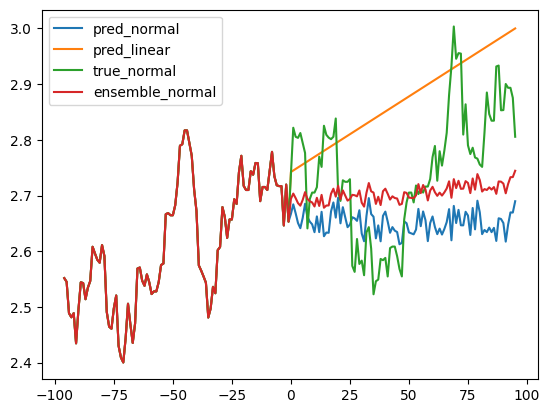

In [55]:
# 그래프 그리기
idx =97
val = 7
xval = range(96)
xval2 = range(-96, 96)
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val], np_pred[idx, :, val]]), label='pred_normal')
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val],np_pred_lin[idx, :, val]]), label='pred_linear')
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val],np_true[idx, :, val]]), label='true_normal')
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val],final_res_scale[idx, :, val]]), label='ensemble_normal')
plt.legend()
plt.savefig('aux_graph_ensemble.png')
plt.show()

In [56]:
a,b,c

(0.3694968819618225, 0.16575488448143005, 0.154603973031044)

In [57]:
# 메트릭 비교하기 (원본 iTransformer)
MSE(np_pred[:,:,-1], np_true[:,:,-1]), MAE(np_pred[:,:,-1], np_true[:,:,-1]), SMAE(np_pred[:,:,-1], np_true[:,:,-1]), 

(0.10463235, 0.24067545, -0.053103354)

In [58]:
# 메트릭 비교하기 (스케일 수정)
MSE(final_res_scale[:,:,-1], np_true[:,:,-1]), MAE(final_res_scale[:,:,-1], np_true[:,:,-1]), SMAE(final_res_scale[:,:,-1], np_true[:,:,-1]), 

(0.12103606, 0.25806978, -0.03141044)

In [59]:
# 초기값 재수정

In [60]:
combine_model_test_2 = CombinedModel(res_iTransformer, res_lin_reg, res_lin_reg_24)
combine_model_test_2.a = nn.Parameter(torch.ones(1, device=exp_model.device)*1e-5, requires_grad=True)

In [61]:
combine_model_test_2.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combine_model_test_2.parameters(), lr=0.001)

In [62]:
cnt = 0
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    # if i in selected_indices:
        cnt += 1
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
        targets = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        optimizer.zero_grad()
        outputs = combine_model_test_2(batch_x)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (cnt+1) % 100 == 0:
            print(f"batch {cnt+1} done, loss {loss}") 

batch 100 done, loss 0.3362267017364502
batch 200 done, loss 0.27020567655563354
batch 300 done, loss 0.28735142946243286
batch 400 done, loss 0.12509576976299286
batch 500 done, loss 0.2961752414703369


In [63]:
combine_model_test_2.a, combine_model_test_2.b, combine_model_test_2.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.2794], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2696], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2431], device='cuda:0', requires_grad=True))

In [64]:
# 2nd try
cnt = 0
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    # if i in selected_indices:
        cnt += 1
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
        targets = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        optimizer.zero_grad()
        outputs = combine_model_test_2(batch_x)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (cnt+1) % 100 == 0:
            print(f"batch {cnt+1} done, loss {loss}") 

batch 100 done, loss 0.22533826529979706
batch 200 done, loss 0.07487493753433228
batch 300 done, loss 0.0835953950881958
batch 400 done, loss 0.11616598069667816
batch 500 done, loss 0.2506149113178253


In [65]:
combine_model_test_2.a, combine_model_test_2.b, combine_model_test_2.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.3688], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.3031], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2262], device='cuda:0', requires_grad=True))

In [66]:
#3rd try
cnt = 0
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    # if i in selected_indices:
        cnt += 1
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
        targets = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        optimizer.zero_grad()
        outputs = combine_model_test_2(batch_x)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (cnt+1) % 100 == 0:
            print(f"batch {cnt+1} done, loss {loss}") 

batch 100 done, loss 0.22360116243362427
batch 200 done, loss 0.07377588748931885
batch 300 done, loss 0.07840695977210999
batch 400 done, loss 0.09101520478725433
batch 500 done, loss 0.2306041121482849


In [67]:
combine_model_test_2.a, combine_model_test_2.b, combine_model_test_2.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.4410], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2956], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1796], device='cuda:0', requires_grad=True))

In [68]:
#4th try
cnt = 0
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    # if i in selected_indices:
        cnt += 1
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
        targets = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        optimizer.zero_grad()
        outputs = combine_model_test_2(batch_x)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (cnt+1) % 100 == 0:
            print(f"batch {cnt+1} done, loss {loss}") 

batch 100 done, loss 0.21590641140937805
batch 200 done, loss 0.0745122954249382
batch 300 done, loss 0.07789862155914307
batch 400 done, loss 0.07219938933849335
batch 500 done, loss 0.21560607850551605


In [69]:
combine_model_test_2.a, combine_model_test_2.b, combine_model_test_2.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.5139], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2760], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1407], device='cuda:0', requires_grad=True))

In [70]:
#5th try
cnt = 0
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_exchange_96_loader):
    # if i in selected_indices:
        cnt += 1
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
        targets = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        optimizer.zero_grad()
        outputs = combine_model_test_2(batch_x)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (cnt+1) % 100 == 0:
            print(f"batch {cnt+1} done, loss {loss}") 

batch 100 done, loss 0.21033066511154175
batch 200 done, loss 0.07652045786380768
batch 300 done, loss 0.07783327251672745
batch 400 done, loss 0.05993844196200371
batch 500 done, loss 0.20495903491973877


In [71]:
combine_model_test_2.a, combine_model_test_2.b, combine_model_test_2.c # train 되지 않은 상태

(Parameter containing:
 tensor([0.5827], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2488], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1114], device='cuda:0', requires_grad=True))

In [72]:
MSE(preds_te_tr, trues_te_tr), MAE(preds_te_tr, trues_te_tr), SMAE(preds_te_tr, trues_te_tr)

(0.24289308, 0.3400539, 0.23297872)

In [73]:
# 실제 테스트 셋 불러와서 처리
a2, b2, c2 = combine_model_test_2.a[0].item(), combine_model_test_2.b[0].item(), combine_model_test_2.c[0].item()

In [74]:
MSE(a2*preds_te_tr + b2*preds_te_lin + c2*preds_te_lin_24, trues_te_tr), MAE(a2*preds_te_tr + b2*preds_te_lin + c2*preds_te_lin_24, trues_te_tr),  SMAE(a2*preds_te_tr + b2*preds_te_lin + c2*preds_te_lin_24, trues_te_tr)

(0.15464593, 0.2678104, 0.13507202)

In [75]:
a3, b3, c3 = a2/(a2+b2+c2), b2/(a2+b2+c2), c2/(a2+b2+c2)

In [76]:
MSE(a3*preds_te_tr + b3*preds_te_lin + c3*preds_te_lin_24, trues_te_tr), MAE(a3*preds_te_tr + b3*preds_te_lin + c3*preds_te_lin_24, trues_te_tr),  SMAE(a3*preds_te_tr + b3*preds_te_lin + c3*preds_te_lin_24, trues_te_tr)

(0.16143191, 0.27067754, 0.14430898)

In [77]:
print(a2,b2,c2)
print(a3,b3,c3)

0.582700788974762 0.24884004890918732 0.1114090234041214
0.6179552199931309 0.2638953131286021 0.11814946687826704


In [78]:
# 마지막으로 비교
final_res1 = a2*np_pred + b2* np_pred_lin + c2*np_pred_lin_24
final_res_scale1 =a3*np_pred + b3*np_pred_lin + c3*np_pred_lin_24

In [79]:
# 메트릭 비교하기 (원본 iTransformer)
MSE(np_pred, np_true), MAE(np_pred, np_true), SMAE(np_pred, np_true), REC_CORR(np_pred, np_true), STD_RATIO(np_pred, np_true), SLOPE_RATIO(np_pred, np_true)

(0.11036256,
 0.23223016,
 -0.08025815,
 0.005696640664425866,
 3.9565752,
 0.36128828830492915)

In [80]:
# 메트릭 비교하기 (조합)
MSE(final_res1, np_true), MAE(final_res1, np_true), SMAE(final_res1, np_true), REC_CORR(final_res1, np_true), STD_RATIO(final_res1, np_true), SLOPE_RATIO(final_res1, np_true)

(0.11205112,
 0.24141164,
 0.038456593,
 0.050465011421448214,
 3.4799862,
 0.37366631284780505)

In [81]:
# 메트릭 비교하기 (조합)
MSE(final_res_scale1, np_true), MAE(final_res_scale1, np_true), SMAE(final_res_scale1, np_true), REC_CORR(final_res_scale1, np_true), STD_RATIO(final_res_scale1, np_true), SLOPE_RATIO(final_res_scale1, np_true)

(0.11406708,
 0.23622599,
 -0.05340391,
 0.050465004319320834,
 3.3022194,
 0.3761559599377632)

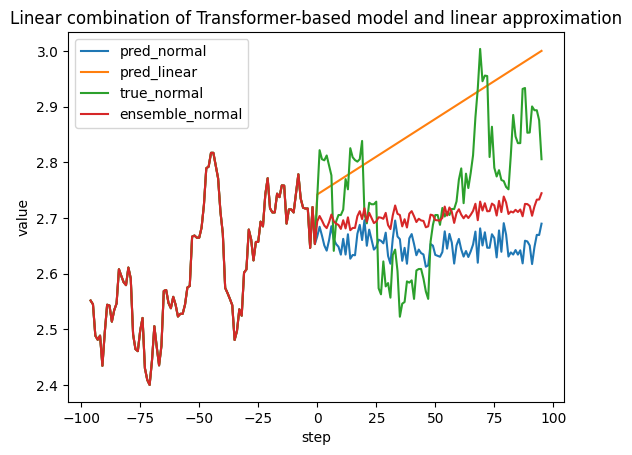

In [96]:
# 그래프 그리기
idx = 97
val = 7
xval = range(96)
xval2 = range(-96, 96)
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val], np_pred[idx, :, val]]), label='pred_normal')
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val],np_pred_lin[idx, :, val]]), label='pred_linear')
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val],np_true[idx, :, val]]), label='true_normal')
plt.plot(xval2, np.concatenate([np_true[idx-96, :, val],final_res_scale[idx, :, val]]), label='ensemble_normal')
plt.xlabel('step')
plt.ylabel('value')
plt.title('Linear combination of Transformer-based model and linear approximation')
plt.legend()
plt.savefig('aux_combination_graph.png')
plt.show()

In [83]:
a,b,c

(0.3694968819618225, 0.16575488448143005, 0.154603973031044)

In [84]:
# 메트릭 비교하기 (원본 iTransformer)
MSE(np_pred[:,:,-1], np_true[:,:,-1]), MAE(np_pred[:,:,-1], np_true[:,:,-1]), SMAE(np_pred[:,:,-1], np_true[:,:,-1]), 

(0.10463235, 0.24067545, -0.053103354)

In [85]:
# 메트릭 비교하기 (스케일 수정)
MSE(final_res_scale[:,:,-1], np_true[:,:,-1]), MAE(final_res_scale[:,:,-1], np_true[:,:,-1]), SMAE(final_res_scale[:,:,-1], np_true[:,:,-1]), 

(0.12103606, 0.25806978, -0.03141044)

In [86]:
import os

import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler


# 선형 회귀 계산
def linear_regression_direct(X, y, device=None):
    """
    선형 회귀 해를 행렬 곱셈으로 직접 계산합니다.
    X: 입력 feature 행렬, shape: [seq_len, 1] 
    y: 타겟 값, shape: [seq_len]
    """
 
    # X에 bias term 추가 (ones column 추가)
    X_b = torch.cat([torch.ones((X.shape[0], 1)), torch.tensor(X, dtype=torch.float32, requires_grad=True)], dim=1).to(device)
    
    # y를 텐서로 변환
    y_torch = torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device).unsqueeze(1)

    # (X^T X) theta = X^T y 를 풀기 위해 solve() 사용
    XTX = X_b.T @ X_b  # X^T X
    XTy = X_b.T @ y_torch  # X^T y

    # torch.linalg.solve()을 사용하여 해 구하기
    theta_best = torch.linalg.solve(XTX, XTy)

    # θ (bias, weight) 반환
    return theta_best

def linear_predict(X_new, theta_best, device=None):
    """
    새로운 입력 데이터 X_new에 대해 예측값을 계산합니다.
    X_new: 새로운 input features, shape: [pred_len, 1]
    theta_best: 학습된 선형 회귀 계수 (bias와 weight)
    """
    # X_new에 bias term 추가

    # X가 numpy array인 경우 텐서로 변환
    # if isinstance(X_new, np.ndarray):
    #     X_new = torch.tensor(X_new, dtype=torch.float32, requires_grad=True).to(device)
    # if isinstance(theta_best, np.ndarray):
    #    theta_best = torch.tensor(theta_best, dtype=torch.float32, requires_grad=True).to(device)

    X_new_b = torch.cat([torch.ones((X_new.shape[0], 1)), torch.tensor(X_new, dtype=torch.float32)], dim=1).to(device)

    # θ (bias, weight)를 사용하여 예측값 계산
    y_pred = X_new_b @ theta_best  # 행렬 곱셈
    return y_pred.squeeze(1)  # 예측 결과를 반환






In [87]:
setting_path = "long_term_forecast_iTransformer_weather_96_96_Mod-iTransformer_data-weather.csv_(96to96)_0(1727247965)"

q1, q2 = "lin96", "lin24"

# 실제 데이터 셋 호출
result_list = ['pred.npy', 'true.npy']
result_path = './results/'
np_pred = np.load(f"{result_path}{setting_path}/{result_list[0]}")
np_true = np.load(f"{result_path}{setting_path}/{result_list[1]}")

X = np.array([[t] for t in range(-96, 0)])  # X는 입력 feature, shape: [seq_len, 1]
X_new = np.array([[t] for t in range(len(np_pred[0]))])  # 예측을 위한 새로운 시간 변수
X_concat = np.concatenate([X, X_new], axis=0).reshape(-1)

scaler = StandardScaler()
df_raw = pd.read_csv('./dataset/weather/weather.csv')
cols = list(df_raw.columns)
cols.remove('date')
cols.remove('OT')
num_total = len(df_raw)
num_train = int(num_total * 0.7)
num_test = int(num_total * 0.2)
num_vali = num_total - num_train - num_test
border1s = [0, num_train - 96, num_total - num_test - 96]
border2s = [num_train, num_train + num_vali, num_total]
border1 = border1s[2]
border2 = border2s[2]
cols_data = df_raw.columns[1:]
df_data = df_raw[cols_data]

train_data = df_data[border1s[0]:border2s[0]]
scaler.fit(train_data.values)
data = scaler.transform(df_data.values)
data_x = data[border1:border2]

dataset_input_test = [data_x[j:j+96, :] for j in range(10635-96+1)]



In [88]:
data_x.shape

(10635, 21)

In [89]:
dataset_input_test = [data_x[j:j+96, :] for j in range(10635-96+1)]

In [90]:
# 선형회귀 계수 결과값으로 계산
def get_np_pred_lin(np_pred, reg_size=96):
    # 이제 계산도 한다
    # 각 배치와 변수에 대해 선형 회귀 해를 계산
    B, L, N = np_pred.shape  # L은 시퀀스 길이(seq_len)
    vals = [[linear_regression_direct(X[-reg_size:], dataset_input_test[idx][-reg_size:, var]) for var in range(N)] for idx in range(B)]
    lin_result = [[linear_predict(X_new, vals[idx][var]) for var in range(N)] for idx in range(B)]
    # 결과를 numpy 모듈로 변경
    np_pred_lin = torch.stack([torch.stack(lin_result[idx], dim=0) for idx in range(B)], dim=0).to(device).permute(0,2,1).detach().cpu().numpy()
    return np_pred_lin

# q1, q2가 잇을 때 

if q1 == "lin96":
    np_pred_first = get_np_pred_lin(np_pred, 96)
    print("PRED_96_DONE")
elif q1 == "lin48":
    np_pred_first = get_np_pred_lin(np_pred, 48)
    print("PRED_48_DONE")
elif q1 == "lin24":
    np_pred_first = get_np_pred_lin(np_pred, 24)
    print("PRED_24_DONE")
elif q1 == "lin12":
    np_pred_first = get_np_pred_lin(np_pred, 12)
    print("PRED_12_DONE")

if q2 == "lin96":
    np_pred_second = get_np_pred_lin(np_pred, 96)
    print("PRED_96_DONE")
elif q2 == "lin48":
    np_pred_second = get_np_pred_lin(np_pred, 48)
    print("PRED_48_DONE")
elif q2 == "lin24":
    np_pred_second = get_np_pred_lin(np_pred, 24)
    print("PRED_24_DONE")
elif q2 == "lin12":
    np_pred_second = get_np_pred_lin(np_pred, 12)
    print("PRED_12_DONE")
elif q2 == "none":
    np_pred_second = np.zeros(np_pred.shape)
    print("NO_DONE")


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed